In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_slsqp, least_squares

In [2]:
%matplotlib inline

In [3]:

# -------------------------------------------------------------------------
# Const
# -------------------------------------------------------------------------
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.  # knots to m/s
omega=2*np.pi/(3600.*24.) # angular speed omega=2pi*f(=frequency of earth : 1 cycle per day) 2pi* 1 / day in seconds
rhoa=1.15 #air density  Kg/m^3
radius=6378388 #137. # earth's radius according to WGS 84
deg2m=np.pi*radius/180.  # ds on cicle equals ds=r*dth - dth=pi/180
pn=101000.  # Atmospheric pressure [N/m^2] (101KPa - enviromental pressure)

tetaNE=45. #mean angle [degrees] of North Eastern quadrant
tetaNW=135. #        "              North Western
tetaSW=225. #        "              South West
tetaSE=315. #        "              South East

maxR=500.e3  # maximum radius of TC [m] (500Km)

In [4]:
kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
kmax=0.25 # upper limit for k (->xn=.65)  WHY?
k0=.1 # initial estimation of holland parameter k

dpmin=10.e2  # minimum value of  pressure drop P_central - P_env(=101kPa).
dpmax=200.e2   # maximum value of  pressure drop P_central - P_env(=101kPa).
dp0=400. #initial estimation of holland parameter dp

rvmaxmin=10.e3  # default minimum value of Rmax[m] 
rmax0=20.e3  # intial estimation for radius of maximum wind [m] (20km)
rmaxmin=5.e3 # intial estimation for radius of maximum wind [m] (5km)

bmin=0.8 # minimum value of holland parameter b
#bmax=2.5
bmax=2.5  # maximum value of holland parameter b
b0=1.2  # initial estimation of holland parameter b

In [5]:
fk=0.92  # coefficient for going from 1m to 10m in velocities

In [6]:
radcols=['64ne', '64se', '64sw', '64nw', '50ne', '50se', '50sw', '50nw',
       '34ne', '34se', '34sw', '34nw']

In [7]:
cols=['w'+ name for name in radcols]

In [8]:
def hvel(r,dph,bh,rmaxh,kh):
    x=0.5+(r-rmaxh)/(maxR-rmaxh)*kh
    return (bh/rhoa*(rmaxh/r)**bh*dph*np.exp(-(rmaxh/r)**bh))**x

In [9]:
rh=np.linspace(0.01,maxR,100)

### read TC data

In [10]:
path='test/'

In [11]:
tc=pd.read_csv(path+'step2.txt',delimiter='\t')

In [12]:
tc

,time,t,hurName,lat,lon,pcenter,penv,rmax,vmax,34ne,...,w64nw,w50ne,w50se,w50sw,w50nw,w34ne,w34se,w34sw,w34nw,vmax0vt
0,0.0,2010-10-29 06:00:00,INVEST,9.0,-53.7,1006,1009,222240.0,15.433333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.069814
1,6.0,2010-10-29 12:00:00,INVEST,9.8,-55.3,1003,1009,166680.0,18.005556,138900.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,17.394121,0.000000,18.059481,16.718113,18.059481
2,12.0,2010-10-29 18:00:00,TOMAS,10.8,-56.8,998,1009,55560.0,23.150000,166680.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,18.074184,17.313465,18.366306,17.301589,18.366306
3,18.0,2010-10-30 00:00:00,TOMAS,11.9,-57.8,999,1009,55560.0,28.294444,166680.0,...,0.000000,23.106896,0.000000,25.859722,0.000000,18.316167,17.397022,18.525193,17.452947,25.859722
4,24.0,2010-10-30 06:00:00,TOMAS,12.7,-58.9,997,1009,55560.0,30.866667,166680.0,...,0.000000,23.344100,0.000000,25.728973,0.000000,18.496702,17.636008,18.632523,17.383112,25.728973
5,30.0,2010-10-30 12:00:00,TOMAS,13.1,-60.1,993,1009,37040.0,33.438889,222240.0,...,30.031688,24.748161,25.130682,25.443546,24.067929,19.599667,17.745589,18.645319,17.719449,30.031688
6,36.0,2010-10-30 18:00:00,TOMAS,13.3,-61.0,990,1009,37040.0,41.155556,222240.0,...,30.216264,24.889111,24.963993,25.297372,24.185329,19.678071,17.715329,18.630080,17.783646,33.720308
7,42.0,2010-10-31 00:00:00,TOMAS,13.5,-61.7,982,1009,37040.0,43.727778,222240.0,...,30.399362,24.927226,24.798761,25.291917,24.301841,19.727123,17.685447,18.658875,17.847466,36.492381
8,48.0,2010-10-31 06:00:00,TOMAS,13.8,-62.4,983,1009,27780.0,43.727778,222240.0,...,30.297483,25.333873,24.927432,25.512994,24.253146,19.783799,17.750702,18.727010,17.858079,36.023263
9,54.0,2010-10-31 12:00:00,TOMAS,14.0,-63.3,988,1011,27780.0,41.155556,222240.0,...,30.017961,25.320538,25.224808,25.584497,24.095087,19.813501,17.856080,18.784244,17.817282,32.757192


### For one time ... 

In [13]:
it=10

In [14]:
vmax=tc.loc[it].vmax

In [15]:
R=tc.ix[it,radcols].values

In [16]:
V=tc.ix[it,cols].values

In [17]:
vmax0vt = tc.vmax0vt.values[it]

In [18]:
time = tc.time.values[it]

In [19]:
sinfi = tc.sinfi.values[it]

In [20]:
lat=tc.lat.values[it]

In [21]:
w = R > 0.

In [22]:
R = R[w].astype(float)

In [23]:
V = V[w].astype(float)

In [24]:
R,V

(array([  27780.,   27780.,   92600.,   37040.,   74080.,   55560.,
         222240.,   92600.,  166680.,  111120.]),
 array([ 28.68809763,  32.87599512,  24.88534348,  25.69484591,
         25.5121911 ,  23.83453082,  19.84789124,  18.01195988,
         18.83408682,  17.73739542]))

## Calculating using Monte Carlo

In [25]:
nb=10000  #size of random numbers used

In [26]:
npmin=2 # minimum number of velocities in order to...

npv=np.size(V)

In [27]:
if (npv>npmin):
     K=kmin+(kmax-kmin)*np.random.rand(nb)
elif(done):
     K = np.ones(nb)*ktot[t-1] # previous time step
else:
     K = np.ones(nb)*kmin

In [28]:
#  DP
DP=dpmin*(dpmax/dpmin)**np.random.rand(nb)

#  Rmax
rvmaxmin_=np.min([rvmaxmin,np.min(R)*0.5])  # update the minimum  value for Rmax with the R.min/2 from input
RMAX=rvmaxmin_*(np.min(R)*0.99/rvmaxmin_)**np.random.rand(nb) # range  min(10000,Rmin/2)<Rmax<.99*Rmin (scaled)

In [29]:
#--------------------------------------------------
# calculate vmax1 = v max0k -vt - Coriolis effect (function of RMAX)
#--------------------------------------------------
deltalatvmax=RMAX/deg2m*sinfi  # for each Rmax we compute the lat deviation for the velocity
latvmax=lat+deltalatvmax

fvmax=2*omega*np.abs(np.sin(np.radians(latvmax))) # Coriolis coef f

fvmax2=RMAX*fvmax/2
vmax1=((vmax0vt+fvmax2)**2-fvmax2**2)**0.5
mask=vmax1<np.max(V)
np.copyto(vmax1,np.max(V),where=mask)

#----------------------------------
# use the random values of vmax,dp above we compute b (from Holland 2010 - eqs (7))
#----------------------------------

B=(rhoa*np.exp(1)/DP)*vmax1**2


m=(B >= bmin) & ( B <= bmax) & (lat*latvmax > 0)  # mask B that fits all 3 criteria
nb1 = np.sum(m) #number of 'True' values

#  mask arrays accordingly
K=K[m]
DP=DP[m]
RMAX=RMAX[m]
B = B[m]

nval = np.size(V)  # number of V > 0
Vcalc = []
RMS = np.zeros(nb1)

#try:
#        r
#except NameError:
#        pass
#else:
#        r=None

# check values for all V
for i in range(nval):
      try:
        r = R[i]
        ratio=(r-RMAX)/(maxR-RMAX)
        X=0.5 + np.min([np.max(ratio,0),1])*K   #compute x using random k  & Rmax
        Vcalc=np.append(Vcalc,((B/rhoa) * DP* (RMAX/r)**B * np.exp(-(RMAX/r)**B))**X)  # compute & store V
      except: print 'sys.exit()'

for i in range (nb1):
      try:
        RMS[i]=np.sqrt(np.average((Vcalc[i::nb1]-V)**2))  # compute deviation from estimated and given values
      except : print 'sys.exit()'

value=nb1
totvalue=nb

# -------------------------------------------------------------------------
# select final velocities
# -------------------------------------------------------------------------
m=RMS == np.min(RMS)  #find minimum RMS

# select the minimizing quantities
rmse=RMS[m][0]
dpMC=DP[m][0]
bMC=B[m][0]
rmaxMC=RMAX[m][0]
kMC=K[m][0]

vmax1MC = np.sqrt(bMC*dpMC/(rhoa*np.exp(1)))  # compute estimated vmax


# print on screen
var=[rmse,dpMC,bMC,rmaxMC,kMC ,np.max(V),vmax1MC]
varn=['rmse','dph','bh','rmaxh','kh','np.max(V)','vmax1']

mcdic={el:val for (el,val) in zip(varn,var)}


In [30]:
mcdic

{'bh': 1.0201455576219876,
 'dph': 3352.0713596222708,
 'kh': 0.20922629387641742,
 'np.max(V)': 32.875995116399999,
 'rmaxh': 11150.419692631303,
 'rmse': 2.4021500708119121,
 'vmax1': 33.074366757639972}

In [31]:
for key,val in mcdic.items():
    try:
        exec(key + '=val') 
    except: pass

## Plot profile

In [32]:
xl=np.linspace(-maxR, maxR,1000)
yl=np.linspace(-maxR, maxR,1000)
q1,q2=np.meshgrid(xl,yl)
vtx=tc.iloc[it].vtrx
vty=tc.iloc[it].vtry

In [33]:
def pres(r):
    return pn+dph*np.exp(-(rmaxh/r)**bh)

In [34]:
def hvel2d(l1,l2):
    r=np.sqrt(l1**2+l2**2)
    xh=0.5+(r-rmaxh)/(maxR-rmaxh)*kh
    ur=(bh/rhoa*(rmaxh/r)**bh*dph*np.exp(-(rmaxh/r)**bh))**xh
    theta=np.arctan2(l2,l1)
    ux=-ur*np.sin(theta)
    uy=ur*np.cos(theta)
    return ux+vtx,uy+vty, pres(r)

In [35]:
zx,zy, pr=hvel2d(q1,q2)
vel=np.sqrt(zx**2+zy**2)

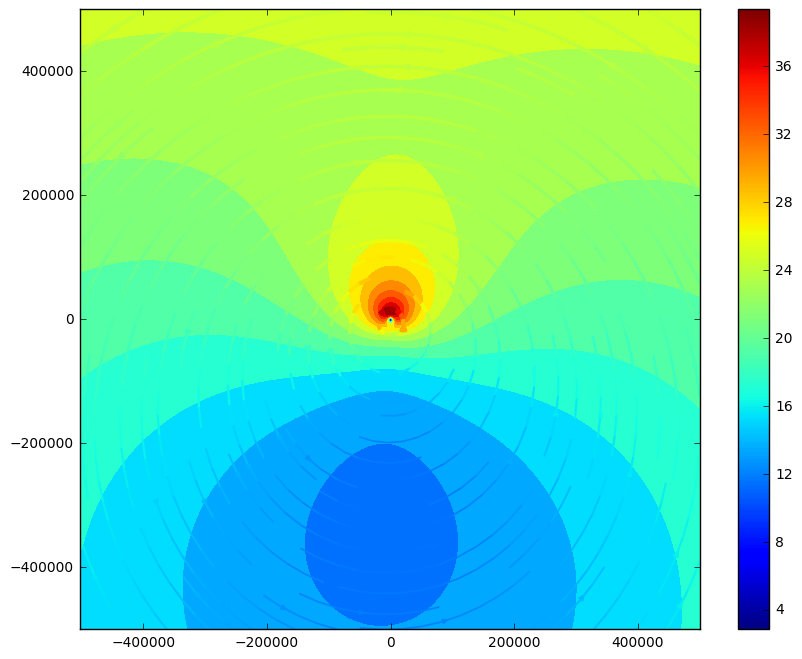

In [36]:
plt.figure(figsize=(10,8))
plt.contourf(q1,q2,vel,20)
plt.streamplot(q1,q2,zx,zy, color=vel, linewidth=0.1*vel)
plt.colorbar()
plt.show()

#  Compute for all time steps

For all times using external scripts

In [37]:
from mc import mc

In [38]:
varn=['rmse','dph','b','rmaxh','k','np.max(V)','vmax1']
mcdic={el:[] for el in varn}

In [39]:
hpar= pd.DataFrame(mcdic)

In [40]:
for it in range(tc.shape[0]):
   
    vmax=tc.loc[it].vmax

#
#try:
#    dp=tc.loc[it].dp
#except:
#    pass

    R=tc.ix[it,radcols].values

    V=tc.ix[it,cols].values

    vmax0vt = tc.vmax0vt.values[it]

    time = tc.time.values[it]

    sinfi = tc.sinfi.values[it]

    lat=tc.lat.values[it]

    w = R > 0.

    R = R[w].astype(float)

    V = V[w].astype(float)

    if R.size > 0 : 
        rmc = mc(R,V,sinfi,lat,vmax0vt)
    else:
        rmc = {el:'' for el in varn}

    df = pd.DataFrame(rmc,index=[it])

    
    hpar = hpar.append(df)
    

In [41]:
hpar.head()

,b,dph,k,np.max(V),rmaxh,rmse,vmax1
0,,,,,,,
1,0.834438,1258.5,0.243277,18.0595,21682.6,0.85146,18.3285
2,0.818659,1329.93,0.237769,18.3663,21661.6,0.640642,18.6625
3,1.07535,1985.44,0.203935,25.8597,18222.7,2.02274,26.134
4,1.12824,1875.97,0.243425,25.729,18239.8,1.9783,26.0206


## Write outData file

In [43]:
outData = pd.concat([tc,hpar],axis=1) # append the Monte Carlo solution to tc Dataset

In [44]:
outData.head()

,time,t,hurName,lat,lon,pcenter,penv,rmax,vmax,34ne,...,w34sw,w34nw,vmax0vt,b,dph,k,np.max(V),rmaxh,rmse,vmax1
0,0.0,2010-10-29 06:00:00,INVEST,9.0,-53.7,1006,1009,222240.0,15.433333,0.0,...,0.000000,0.000000,5.069814,,,,,,,
1,6.0,2010-10-29 12:00:00,INVEST,9.8,-55.3,1003,1009,166680.0,18.005556,138900.0,...,18.059481,16.718113,18.059481,0.834438,1258.5,0.243277,18.0595,21682.6,0.85146,18.3285
2,12.0,2010-10-29 18:00:00,TOMAS,10.8,-56.8,998,1009,55560.0,23.150000,166680.0,...,18.366306,17.301589,18.366306,0.818659,1329.93,0.237769,18.3663,21661.6,0.640642,18.6625
3,18.0,2010-10-30 00:00:00,TOMAS,11.9,-57.8,999,1009,55560.0,28.294444,166680.0,...,18.525193,17.452947,25.859722,1.07535,1985.44,0.203935,25.8597,18222.7,2.02274,26.134
4,24.0,2010-10-30 06:00:00,TOMAS,12.7,-58.9,997,1009,55560.0,30.866667,166680.0,...,18.632523,17.383112,25.728973,1.12824,1875.97,0.243425,25.729,18239.8,1.9783,26.0206


### specify the output format for the outData.txt file in the operational workflow

In [45]:
header=['time','xhc','yhc','b','k','rmax','deltap','vmax','vmax0','vtr','vtrx','vtry','bias','rmse']

In [46]:
outData.columns.values

array(['time', 't', 'hurName', 'lat', 'lon', 'pcenter', 'penv', 'rmax',
       'vmax', '34ne', '34se', '34sw', '34nw', '50ne', '50se', '50sw',
       '50nw', '64ne', '64se', '64sw', '64nw', 'dp', 'vtrx', 'vtry', 'vtr',
       'cosfi', 'sinfi', 'w64ne', 'w64se', 'w64sw', 'w64nw', 'w50ne',
       'w50se', 'w50sw', 'w50nw', 'w34ne', 'w34se', 'w34sw', 'w34nw',
       'vmax0vt', 'b', 'dph', 'k', 'np.max(V)', 'rmaxh', 'rmse', 'vmax1'], dtype=object)

In [47]:
column_order=['time','lat','lon','b','k','rmaxh','dph','vmax','vmax0','vtr','vtrx','vtrxy','bias','rmse']

In [48]:
outData.to_csv(path+'outData.txt',index=False, columns=column_order, sep='\t',header=header)

### save the complete dataset as step 3 of the analysis

In [49]:
outData.to_csv(path+'step3.txt',index=False, sep='\t')

## Compare estimations with available values in the read-in dataset

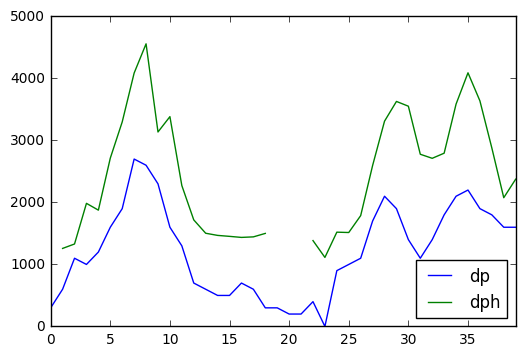

In [53]:
outData[['dp','dph']].apply(pd.to_numeric).plot()

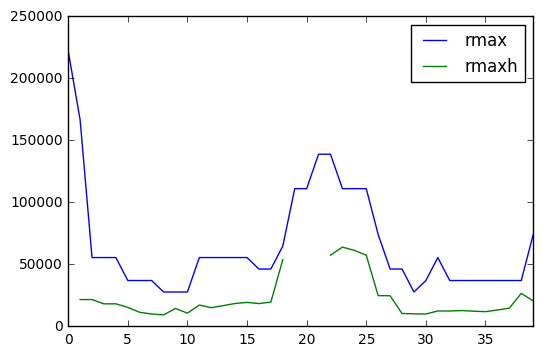

In [54]:
outData[['rmax','rmaxh']].apply(pd.to_numeric).plot()